In [1]:
from google.colab import drive
drive.mount('/gdrive6')  #Mount your drive

Mounted at /gdrive6


In [2]:
cd '/gdrive6/My Drive/Colab Notebooks/img_captioning/'

/gdrive6/My Drive/Colab Notebooks/img_captioning


In [3]:
import torch
from tqdm import tqdm
import torch.nn as nn
import statistics
import torchvision.models as models

import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from utils import save_checkpoint, load_checkpoint, print_examples
from get_loader import get_loader


## Image Encoder, Text Decoder

An encoder that encodes images, and a decoder that decodes text, giving us an image captioning model.

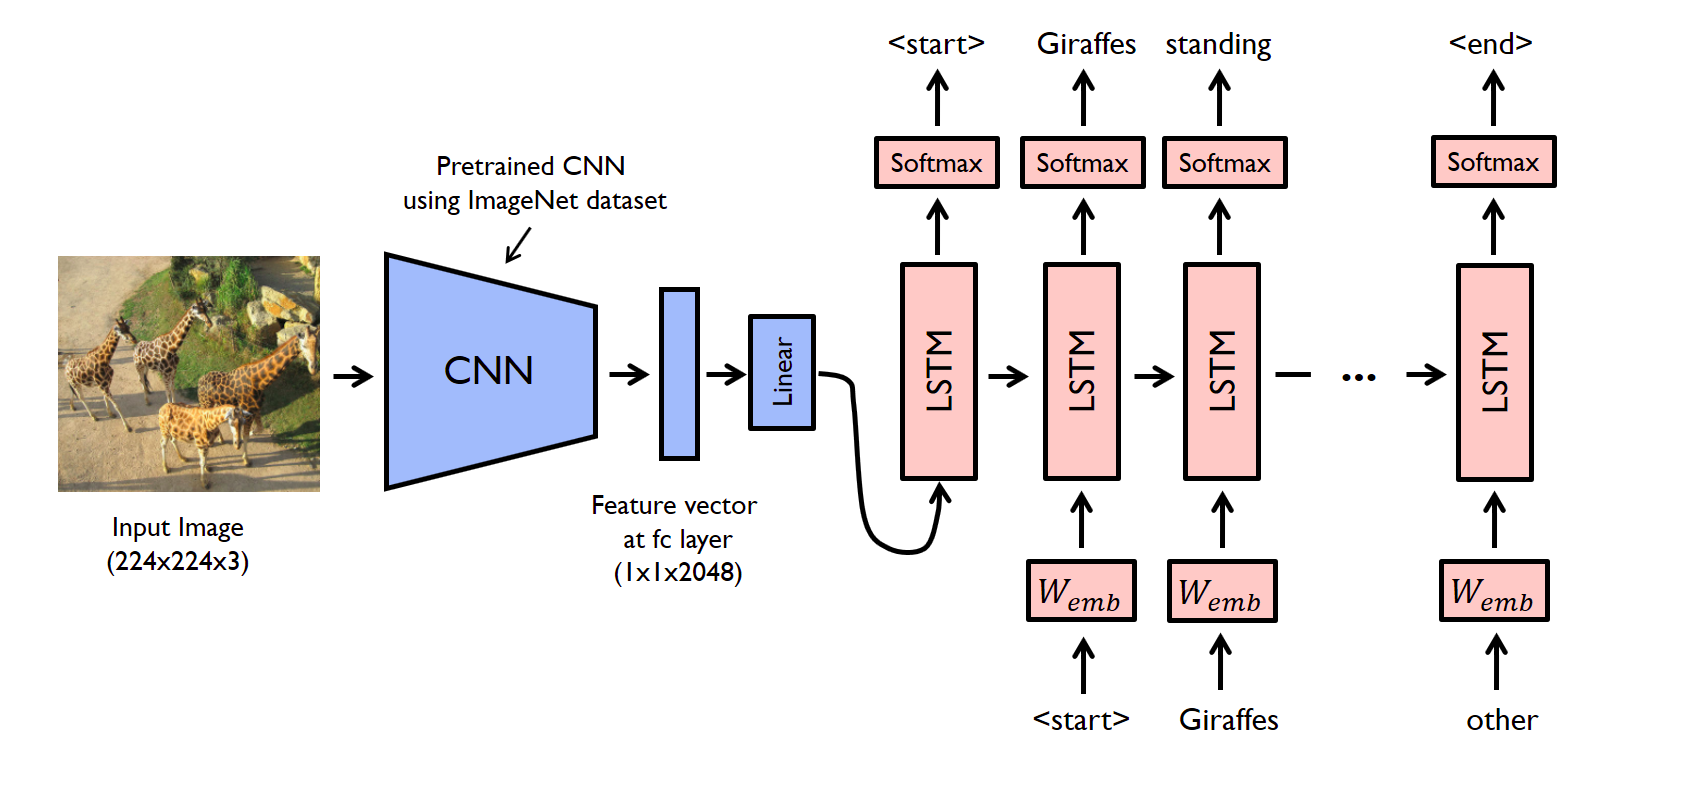

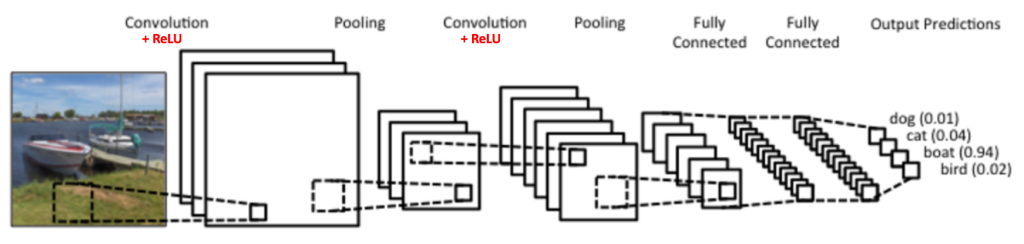

In [10]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True)
        self.inception.aux_logits=False
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [13]:
def train():
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder="flickr8k/images",
        annotation_file="flickr8k/captions.txt",
        transform=transform,
        num_workers=2,
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = True
    train_CNN = False

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 100

    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    if load_model:
        step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):
        # Uncomment the line below to see a couple of test cases
        print_examples(model, device, dataset)

        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)

        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()





In [ ]:
train()

Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: scene boxer husky shoulders striking snowing sides skaters meal reception jumper swim protest square village podium train dangling mustache forest dribbling dribbling hamburgers blindfolded leafy going snarling border flaming owners go racer runners baby happily apart past clouds tops tops tights dunking crowded swim podium ' hard tee spotlight newborn
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: scene boxer husky shoulders striking snowing sides skaters meal reception jumper swim protest square village podium train dangling mustache forest dribbling dribbling hamburgers blindfolded leafy going snarling border flaming owners go racer runners baby happily apart past clouds tops tops tights dunking crowded swim podium ' hard tee spotlight newborn
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: scene boxer husky shoulders striking snowing sides skaters meal reception jumper swim pro

Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is riding a bike in a red shirt . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is riding a bike in a red shirt . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is riding a bike in a red shirt . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is riding a bike in a red shirt . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is riding a bike in a red shirt . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is riding a bike on a skateboard . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is riding a bike on a skateboard . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is riding a bike on a skateboard . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the grass . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a swing . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is riding a bike on a ramp . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the grass . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is standing on a swing . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is sitting on a bench with a <UNK> in his hand . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is riding a bike on a dirt bike . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the grass . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is playing with a ball in the background . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black shirt is standing on a bench . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is riding a bike on a dirt bike . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt is standing on a bench . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young boy wearing a blue shirt is playing with a ball in a pool . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt is standing on a bench . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is riding a bike on a dirt bike . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through a field . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt and a black shirt is standing in the grass . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black hat is standing in front of a large building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black shirt is riding a bike on a dirt bike . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the grass . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt and a black shirt is playing with a tennis ball . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black jacket is standing on a sidewalk with a <UNK> in the background . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black wetsuit is riding a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the snow . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young boy in a blue shirt is playing with a soccer ball . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black jacket is standing on a sidewalk with a <UNK> in the background . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is riding a bike on a dirt road . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man is standing on a rock overlooking a lake . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is holding a baby in a pool . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a large building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a wetsuit is surfing on a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt is standing on a rock with a dog in the background . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt and a pink shirt is standing in front of a large tree . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a large building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a wetsuit is surfing on a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man is standing on a rock overlooking a lake . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog runs through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young boy in a red shirt is playing with a soccer ball . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black hat is standing in front of a large building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue wetsuit is surfing on a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt and a black dog is running through the snow . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young boy wearing a red shirt is jumping in the air . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a street with a <UNK> in the background . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a wetsuit is surfing on a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a woman are walking on a beach . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt and blue jeans is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a sidewalk with a <UNK> in his hand . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a wetsuit is surfing on a surfboard . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man is standing on a <UNK> in the middle of a mountain . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt and a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt and a black jacket is standing in front of a brick building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is surfing on a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man is standing on a horse in front of a large crowd of people . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is swinging on a swing . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a white shirt and jeans is standing in front of a building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a wetsuit is surfing on a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man is standing on a rock in front of a large building . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little boy in a red shirt is playing with a soccer ball . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a brick wall . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a surfboard in the ocean . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a woman are walking down a path . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a large building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a wetsuit is surfing on a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt is walking on a dirt path . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt and blue jeans is playing with a toy . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt and jeans is standing on a sidewalk . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is kayaking in the water . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt and a brown dog is walking on a dirt path . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a white shirt and a black hat is standing in front of a brick wall . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a yellow kayak is surfing in the ocean . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a rocky shore . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt and a pink hat is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a woman in a black shirt and a black dog are walking down a sidewalk . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a yellow kayak is surfing in the ocean . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt and a brown dog is walking on a dirt path . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a brick building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a surfboard in the ocean . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a rocky shore . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young boy in a red shirt is playing with a soccer ball . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black jacket is standing on a sidewalk with a <UNK> in his hand . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a surfboard in the ocean . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man is walking on a beach with a dog . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black hat is standing in front of a brick wall . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a surfboard in the ocean . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a rocky hill . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a white shirt and jeans is standing in front of a brick wall . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a surfboard in the ocean . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are playing with a ball in the snow . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is swinging on a swing . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a brick building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a wetsuit is surfing on a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is walking on a dirt path . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is holding a pink and blue bat . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a crowd of people . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a boat on a lake . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are running through a field . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a sidewalk with a <UNK> in the background . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a boat on a lake . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are running through a field of dry grass . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog runs through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running on a grassy field . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a sidewalk with a <UNK> in front of him . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue wetsuit is surfing on a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is walking on a dirt path . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a sidewalk with a <UNK> in his hand . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a canoe on a beach . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt is walking on a dirt path . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running through a field . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red jacket is standing in front of a building with a <UNK> . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a boat on a lake . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is walking on a dirt path . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is holding a rope . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a brick building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a boat on a lake . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a group of dogs pulling a sled through the snow . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running on a grassy field . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a sidewalk with a shopping cart . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a boat on a lake . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man is standing on a hill overlooking a valley . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running on a grassy field . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a sidewalk with a man in a red jacket . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue wetsuit is surfing on a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a rocky shore , with a dog in the background . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a brick building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a boat on a lake . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a group of people are riding horses on a trail . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a crowd of people . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a surfboard in the ocean . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt is walking on a dirt path . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is swinging on a swing . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a sidewalk with a man in a red jacket . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a wetsuit is surfing on a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt and a white dog is running on a dirt path . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a <UNK> building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a boat on a lake . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a hill overlooking a valley . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a sidewalk with a crowd of people . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a boat on a lake . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red jacket is walking on a dirt path . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young girl wearing a pink shirt is swinging on a swing . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red jacket is standing in front of a <UNK> building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a yellow kayak is paddling a canoe on a river . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are playing with a ball in the snow . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and tie is standing in front of a brick building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a boat on a lake . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a group of people are riding horses on a trail . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running on a grassy field . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a white building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is surfing in the ocean . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt is walking a dog on a leash . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running through a grassy field . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a brick building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a boat on a lake . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are playing with a ball in the snow . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running on a grassy field . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a sidewalk with a <UNK> in the background . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a boat on a lake . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red jacket is riding a brown horse . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running on a grassy field . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a street corner . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is kayaking in a river . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are playing with a ball in the snow . <EOS>


 46%|████▌     | 581/1265 [03:20<04:57,  2.30it/s]